In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"roshansalian","key":"e39d75e6e585ec5470f827cdf8343728"}'}

In [3]:
!mkdir .kaggle
!cp /content/kaggle.json ~/.kaggle/
!kaggle datasets download -d shobhit18th/indian-currency-notes

mkdir: cannot create directory ‘.kaggle’: File exists
 99% 288M/290M [00:04<00:00, 79.5MB/s]
100% 290M/290M [00:04<00:00, 68.7MB/s]


In [0]:
!unzip indian-currency-notes.zip

In [5]:
train_dir = 'indian_currency_new/training'
valid_dir = 'indian_currency_new/validation'

/content


In [10]:
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255,)
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=False,
      vertical_flip=False,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
        'indian_currency_new/training/',
        target_size=(200, 200),
        batch_size=64,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        'indian_currency_new/validation/',
        target_size=(200, 200),
        batch_size=64,
        class_mode='categorical')

Found 584 images belonging to 7 classes.
Found 167 images belonging to 7 classes.


In [0]:
import tensorflow as tf

In [0]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 95, 95, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)       0

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
callbacks_list = [
                  EarlyStopping(monitor='val_loss', patience=10),
                  ModelCheckpoint(filepath='currency.h5', monitor='val_loss', save_best_only=True),
]

In [29]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
with tf.device('/GPU:0'):
  history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator), epochs=100, validation_data=test_generator, validation_steps=len(test_generator), callbacks=callbacks_list)
  

Epoch 1/100
10/10 [==============================] - 18s 2s/step - loss: 0.4265 - accuracy: 0.1353 - val_loss: 0.4099 - val_accuracy: 0.1437
Epoch 2/100
10/10 [==============================] - 20s 2s/step - loss: 0.4093 - accuracy: 0.1455 - val_loss: 0.4139 - val_accuracy: 0.1497
Epoch 3/100
10/10 [==============================] - 19s 2s/step - loss: 0.4086 - accuracy: 0.2038 - val_loss: 0.4043 - val_accuracy: 0.2216
Epoch 4/100
10/10 [==============================] - 19s 2s/step - loss: 0.3943 - accuracy: 0.2466 - val_loss: 0.3604 - val_accuracy: 0.2994
Epoch 5/100
10/10 [==============================] - 20s 2s/step - loss: 0.3829 - accuracy: 0.2757 - val_loss: 0.3570 - val_accuracy: 0.3234
Epoch 6/100
10/10 [==============================] - 17s 2s/step - loss: 0.3661 - accuracy: 0.2997 - val_loss: 0.3268 - val_accuracy: 0.3114
Epoch 7/100
10/10 [==============================] - 18s 2s/step - loss: 0.3465 - accuracy: 0.3356 - val_loss: 0.3200 - val_accuracy: 0.3114
Epoch 8/100
1

Text(0.5, 0, 'number of epochs')

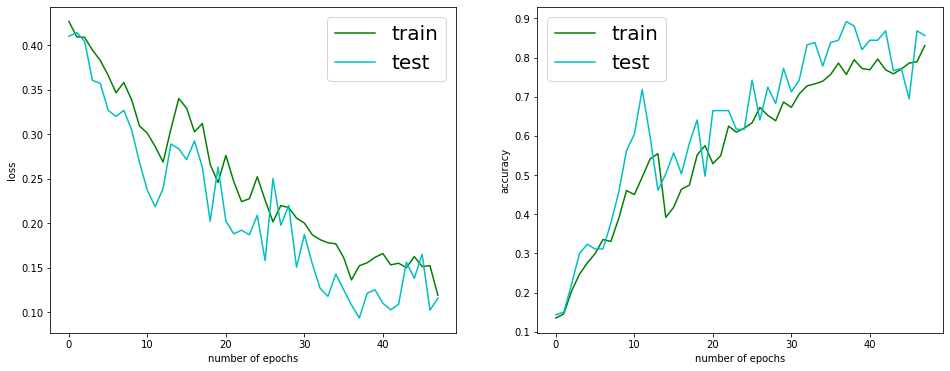

In [31]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'], 'g-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'c-', label='test')
plt.legend(prop={'size':20})
plt.ylabel('loss')
plt.xlabel('number of epochs')
plt.subplot(1, 2, 2)
plt.plot(range(nepochs), history.history['accuracy'], 'g-', label='train')
plt.plot(range(nepochs), history.history['val_accuracy'], 'c-', label='test')
plt.legend(prop={'size':20})
plt.ylabel('accuracy')
plt.xlabel('number of epochs')

In [34]:
_, acc = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=0)
print('> %.3f' % (acc * 100.0))

Instructions for updating:
Please use Model.evaluate, which supports generators.
> 83.832


In [35]:
!pip install tensorflowjs


     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 104.6MB 49.7MB/s 
     |████████████████████████████████| 3.9MB 57.3MB/s 
     |████████████████████████████████| 450kB 75.5MB/s 
     |████████████████████████████████| 256kB 78.6MB/s 
     |████████████████████████████████| 921kB 46.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=f5082d48baa2efef40bbe39f90abd7dfa8b0aad4dbb510edbe9cf86da0d2b2f6
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32851 sha256=98c52007d7a000b19147facfd0e9ac0cdea81b7741a62d46b5c2a61ea3f33584
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built gast PyInquirer
ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERRO

Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/converter.py", line 670, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/converter.py", line 674, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/converter.py", line 592, in convert
    weight_shard_size_bytes=weight_shard_size_bytes)
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/converter.py", line 74, in dispatch_keras_h5_to_tfjs_layers_model_conversion
    raise ValueError('Nonexistent path to HDF5 file: %s' % h5_path)
ValueError: Nonexistent path to HDF5 file: ‘/content/currency.h5’


In [0]:
!tensorflowjs_converter --input_format keras currency.h5 /content

In [0]:
from google.colab import files

# with open('example.txt', 'w') as f:
#   f.write('some content')

files.download('group1-shard2of5.bin')

In [0]:
files.download('group1-shard3of5.bin')

In [0]:
files.download('group1-shard4of5.bin')

In [0]:
files.download('group1-shard5of5.bin')